In [19]:
versioninfo()

Julia Version 1.4.0
Commit b8e9a9ecc6 (2020-03-21 16:36 UTC)
Platform Info:
  OS: Linux (x86_64-pc-linux-gnu)
  CPU: Intel(R) Xeon(R) Platinum 8280 CPU @ 2.70GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-8.0.1 (ORCJIT, skylake)
Environment:
  JULIA_DEPOT_PATH = /work/go85/o85002/.julia
  JULIA_DIR = /work/opt/local/apps/julia/1.4.0


In [20]:
mycommand = `pwd`
run(mycommand)

/work/00/go85/o85002/non_eq_relax/J2_-5e-3/L300


Process(`pwd`, ProcessExited(0))

In [21]:
using Interpolations
using Printf
using Optim
using PyPlot
using LinearAlgebra
using HDF5

In [22]:
function read_from_hdf5(h5file,obs_name)
	fid = h5open(h5file,"r")
	temps = fid["temperatures"][:]
	obs   = fid[obs_name*"/mean"]
	times = [i for i in 1:size(obs)[1]]
	return temps,obs,times
end

read_from_hdf5 (generic function with 1 method)

In [23]:
h5file = "2d_out.h5"
obs_name = "mq_q0_corr"
temps,m_data,times = read_from_hdf5(h5file,obs_name)

([0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04, 0.045, 0.05, 0.055, 0.06, 0.065, 0.07, 0.075, 0.08, 0.085, 0.09, 0.095, 0.1], HDF5 dataset: /mq_q0_corr/mean (file: 2d_out.h5 xfer_mode: 0), [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  9992, 9993, 9994, 9995, 9996, 9997, 9998, 9999, 10000, 10001])

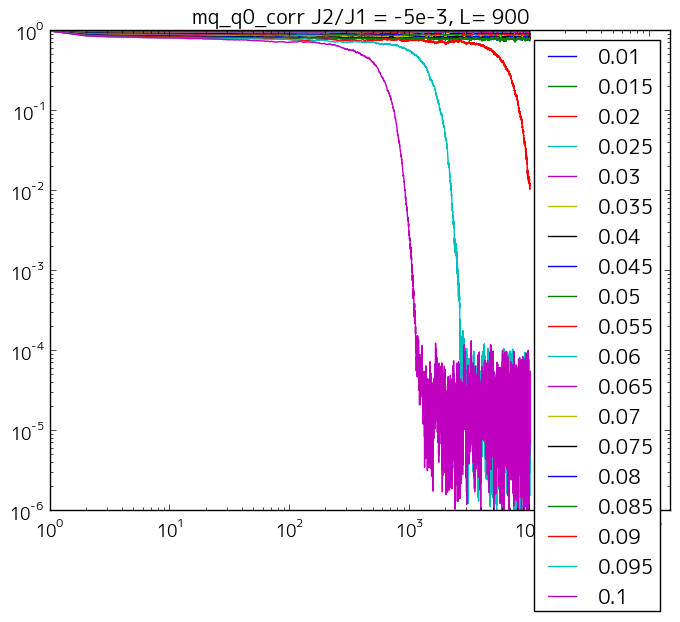

In [24]:
# cut too low temperature datas
num_temps = length(temps)
min_temp  = 1
max_temp  = num_temps
for it in min_temp:max_temp
	plt.semilogy(times,m_data[:,it],label="$(temps[it])")
end
plt.title("$(obs_name) J2/J1 = -5e-3, L= 900")
plt.xscale("log")
plt.xlim(1,length(times)*15)
plt.ylim(1e-6,1)

plt.legend(loc="upper right")
plt.show()

In [25]:
#=
#load average data from text file
temps = [0.112,0.113,0.114,0.115,0.116]
file_idx = [3,4,5,6,7]
num_temps = length(temps)
mc_steps  = 20000 
m_data = Array{Float64}(undef,mc_steps,num_temps)
counter = 1
for ifl in file_idx
	open("mq_sqrt3_$(ifl).dat","r") do fp
		for is in 1:mc_steps
			str = split(readline(fp))
			m_data[is,counter] = parse(Float64,str[2])
		end
	end
	counter += 1
end
=#

In [26]:
m_data

HDF5 dataset: /mq_q0_corr/mean (file: 2d_out.h5 xfer_mode: 0)

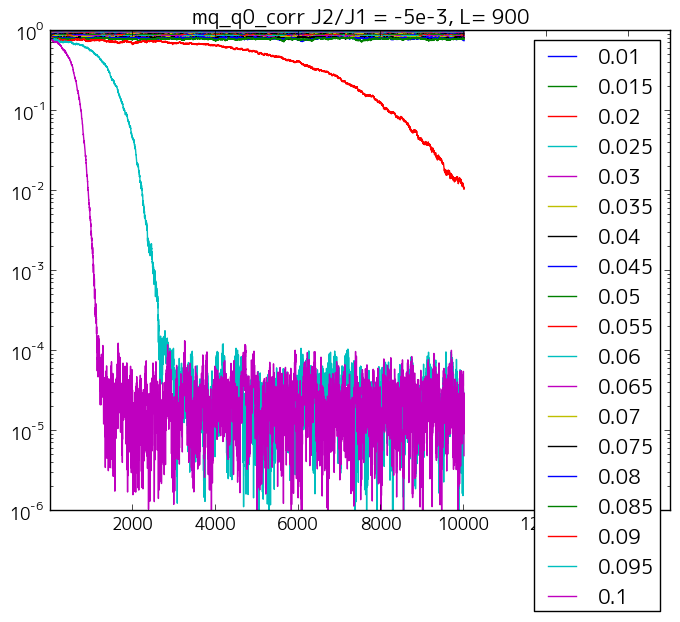

19


In [27]:
num_temps = length(temps)
println(num_temps)
times = [i for i in 1:size(m_data)[1]]
for it in 1:num_temps
	plt.semilogy(times[10:end],m_data[:,it][10:end],label="$(temps[it])")
end
plt.title("$(obs_name) J2/J1 = -5e-3, L= 900")
#plt.xscale("log")
plt.xlim(1,length(times)*1.5)
plt.ylim(1e-6,1)
plt.legend(loc="upper right")
plt.show()

In [28]:
# reshape some datas for optimization.
min_temp = 1
max_temp = 5
temps  = temps[min_temp:max_temp]
num_temps = length(temps)
m_data = m_data[:,min_temp:max_temp]


10001×5 Array{Float64,2}:
 1.0       1.0       1.0       1.0       1.0
 0.986951  0.980553  0.974423  0.96704   0.960686
 0.985009  0.977319  0.970377  0.962495  0.955339
 0.984147  0.975655  0.968513  0.959916  0.952047
 0.983542  0.974993  0.967705  0.958321  0.950415
 0.983091  0.974592  0.967089  0.957774  0.947951
 0.982311  0.973849  0.966154  0.956362  0.948839
 0.98211   0.974054  0.965816  0.956638  0.948506
 0.982653  0.973556  0.965674  0.955469  0.947934
 0.982513  0.973799  0.965385  0.95475   0.946816
 0.982439  0.973339  0.963452  0.955567  0.947192
 0.982021  0.973926  0.962714  0.953727  0.945518
 0.981999  0.973783  0.962324  0.953373  0.946303
 ⋮                                       
 0.97684   0.964428  0.955147  0.936949  0.932942
 0.976135  0.964197  0.954341  0.938647  0.933953
 0.976902  0.964948  0.954584  0.94173   0.933568
 0.976401  0.964523  0.954151  0.940782  0.931826
 0.975894  0.965394  0.953592  0.9388    0.930821
 0.976942  0.96563   0.95466   0.9371

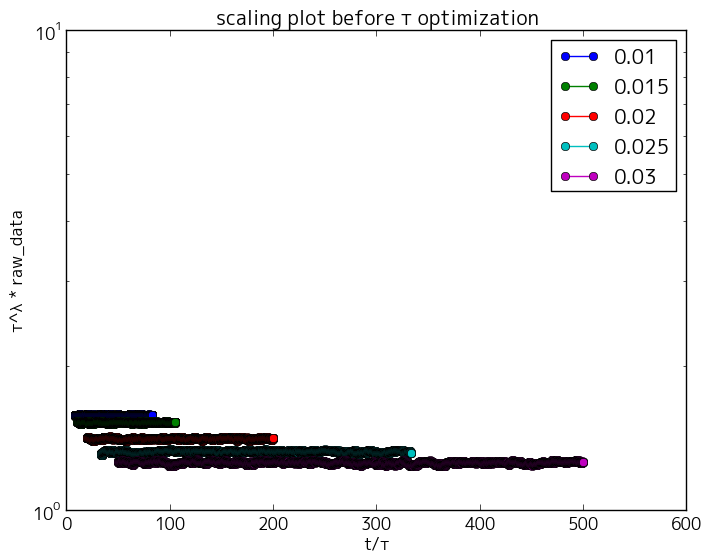

In [29]:
# search configuration of tau which put some curves on one curve.
taus   = [120,95.,50.,30.,20.0]
@assert length(taus) == max_temp - min_temp + 1
lambda = 0.1
start  = 1000
plt.figure()
for it in 1:num_temps
	plt.semilogy(times[start:end] ./ taus[it],(taus[it]^lambda)*m_data[:,it][start:end],marker="o",label="$(temps[it])")
	
end
plt.title("scaling plot before τ optimization")
plt.xlabel("t/τ")
plt.ylabel("τ^λ * raw_data")
plt.legend(loc="upper right")
plt.show()

In [30]:
"""
params: [tau1, tau2, ...]
"""
newaxis = [CartesianIndex()]
function cost(params)
    taus = params
    nx_smpl = 10
    x_u = minimum(times[end] ./ taus)
    x_l = maximum(times[start] ./ taus)
    xs_smpl = range(x_l, x_u, length=nx_smpl)
    g_intpl = zeros((nx_smpl, length(temps)))
    for it in eachindex(temps)
        tau = taus[it]
        xs = times ./ tau
        g_data = tau^lambda * m_data[:, it]
        itp = LinearInterpolation(xs, g_data)        
        g_intpl[:, it] = itp.(xs_smpl)
    end
    g_mean = sum(g_intpl, dims=2) ./ length(temps)
    norm(g_intpl .- g_mean[:, newaxis])^2 /  norm(g_mean)^2
end

cost (generic function with 1 method)

In [31]:
res = Optim.optimize(cost, taus)
res

DomainError: [91mDomainError with -24.311086975999928:[39m
[91mExponentiation yielding a complex result requires a complex argument.[39m
[91mReplace x^y with (x+0im)^y, Complex(x)^y, or similar.[39m

In [32]:
taus_opt = Optim.minimizer(res)

UndefVarError: [91mUndefVarError: res not defined[39m

In [33]:
println("T τ")
for i in 1:num_temps 
	println(temps[i]," ",taus_opt[i])
end


T τ


UndefVarError: [91mUndefVarError: taus_opt not defined[39m

In [34]:
plt.figure()
for it in eachindex(temps)
	plt.semilogy(times[10:end] ./ taus_opt[it], (taus_opt[it]^lambda) * m_data[:, it][10:end], marker="o",label="$(temps[it])")
    #println((taus[it]^lambda) * m_data[:, it])
end
plt.title("scaling plot after τ optimizaton")
plt.xlabel("t/τ")
plt.ylabel("τ^λ * m_data")
plt.legend(loc="upper right")
plt.show()

UndefVarError: [91mUndefVarError: taus_opt not defined[39m

In [35]:
x = 1.0
y = 0.9
n = 100
test = range(x,y,length=n)

1.0:-0.00101010101010101:0.9

In [36]:
test = LinRange(x,y,n)


100-element LinRange{Float64}:
 1.0,0.99899,0.99798,0.99697,0.99596,…,0.90404,0.90303,0.90202,0.90101,0.9